### Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import warnings
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

### Load and format CBP/CMC water quality and benthic data

In [2]:
df = pd.read_csv('Source Data/Water_Final.csv', dtype = 'str')

In [3]:
df['YEAR'] = pd.DatetimeIndex(df['Date']).year

df['MeasureValue'] = df['MeasureValue'].astype('float64')

df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['MeasureValue'] > 30), 'MeasureValue'] = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['MeasureValue'] > 30), 'MeasureValue'] / 100

df['HUC8_'] = df['HUC12_'].str[:8]

In [4]:
benthic = pd.read_csv('Source Data/Benthic_Stream_Health.csv', dtype = str)
benthic['YEAR'] = benthic['sample_date'].str[-4:].astype('int')
benthic.rename(columns = {'HUC12': 'HUC12_'}, inplace = True)
benthic['rating'] = benthic['rating'].map({'excellent': 4, 'good':3, 'fair':2, 'poor':1, 'very_poor':0})

### Watershed Shapefiles

In [5]:
huc_8 = gpd.read_file("Source Data/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU8')
huc_12 = gpd.read_file("Source Data/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU12')

In [6]:
def wsname(code, level_8):
    if level_8:
        return huc_8.loc[huc_8['HUC8'] == code, 'NAME'].values[0]
    else:
        return huc_12.loc[huc_12['HUC12'] == code, 'NAME'].values[0]

### Add longitude and latitude columns to water quality data

In [7]:
df = pd.merge(left = df,
         right = df['Point'].str.replace('POINT \(', '').str.replace('\)', '').str.partition(' ').rename(columns = {0:'Xcoord', 2: 'Ycoord'}).drop(columns = 1),
         how = 'left',
         left_index = True,
         right_index = True)

### Function to generate single-hue colormap with transparent vmin

In [8]:
def colorcmap(color):
    r, g, b = mcolors.to_rgb(color)
    N = 1000
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(r, 1, N, 1)
    vals[:, 1] = np.linspace(g, 1, N, 1)
    vals[:, 2] = np.linspace(b, 1, N, 1)
    vals[:, 3] = np.linspace(0, 1, N, 1)[::-1]
    return mcolors.ListedColormap(vals[::-1])

### Plot Middle Potomac-Catoctin and Rapidan-Upper Rappahannock Boundaries

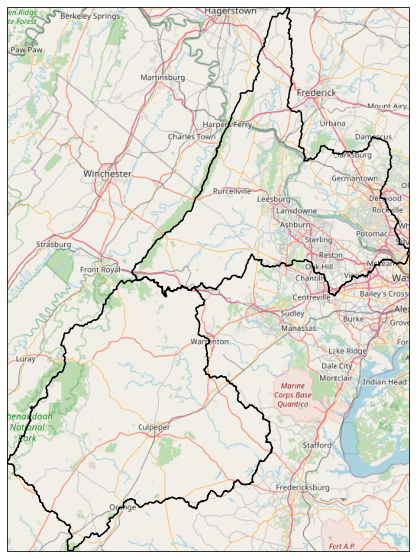

<Figure size 432x288 with 0 Axes>

In [9]:
imagery = OSM()
x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].unary_union.bounds

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

ax.add_image(imagery, 9)

huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].boundary.plot(ax = ax, color = 'k', transform = ccrs.PlateCarree())

plt.show()
plt.savefig('Images/Bounaries.png', transparent = True)

### Plot huc12s with repeated measurements, highlight where benthic rating has improved for 3 years

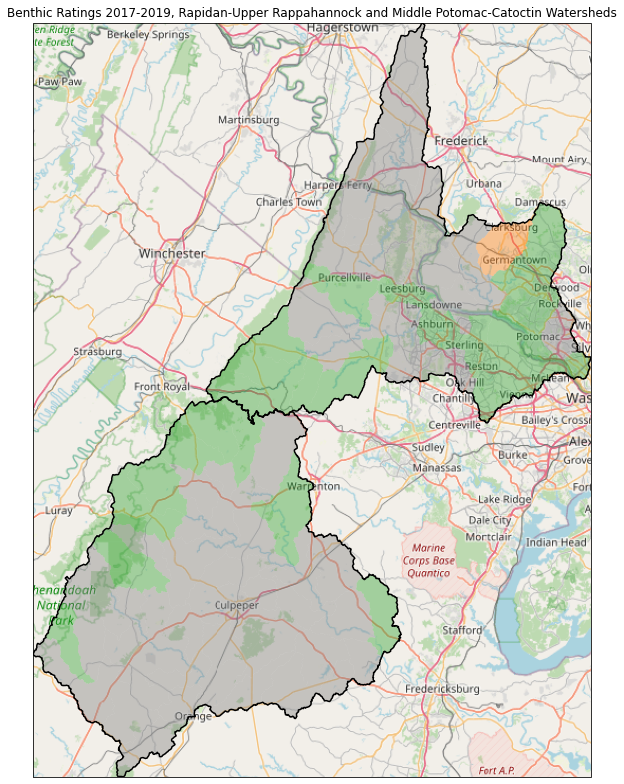

In [10]:
imagery = OSM()
x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].unary_union.bounds

fig = plt.figure(figsize = (10, 15))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

ax.add_image(imagery, 9)

huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].boundary.plot(ax = ax, color = 'k', transform = ccrs.PlateCarree())

improved, benthicdata, nobenthicdata = (0,0,0)

for huc12 in huc_12.loc[(huc_12['HUC12'].str.startswith('02080103') | huc_12['HUC12'].str.startswith('02070008')), 'HUC12']:
    if huc12 in benthic.loc[((benthic['HUC12_'].str.startswith('02080103')) | (benthic['HUC12_'].str.startswith('02070008'))) & (benthic['YEAR'].isin(np.arange(2017,2020)))].pivot_table(index = 'HUC12_', columns = 'YEAR', aggfunc = 'mean').dropna().reset_index()['HUC12_'].values:
        if (
            (benthic.loc[benthic['HUC12_'] == huc12].groupby('YEAR').mean()['rating'][2019] > benthic.loc[benthic['HUC12_'] == huc12].groupby('YEAR').mean()['rating'][2018]) and
            (benthic.loc[benthic['HUC12_'] == huc12].groupby('YEAR').mean()['rating'][2018] > benthic.loc[benthic['HUC12_'] == huc12].groupby('YEAR').mean()['rating'][2017])
        ):
            improved +=1
            color = 'tab:orange'
            label = 'Benthic Rating Improved 2017-2019'
        else:
            benthicdata +=1
            color = 'tab:green'
            label = 'Benthic Rating Available 2017-2019'
    else:
        nobenthicdata +=1
        color = 'tab:grey'
        label = 'No Benthic Rating Available 2017-2019'
    huc_12.loc[huc_12['HUC12'] == huc12].plot(ax = ax, color = color, alpha = 0.4, transform = ccrs.PlateCarree(), label = label)

plt.title("Benthic Ratings 2017-2019, Rapidan-Upper Rappahannock and Middle Potomac-Catoctin Watersheds");
plt.savefig('Images/BenthicRatings.png', transparent = True)

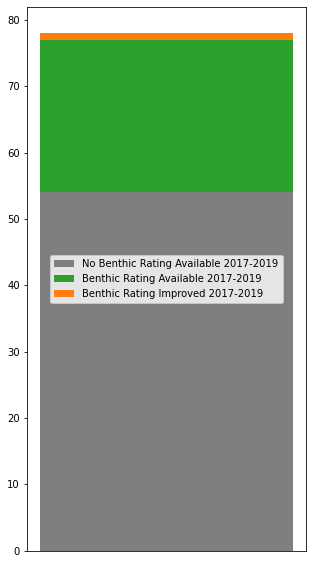

In [11]:
plt.figure(figsize = (5, 10))
plt.bar(x = 1, height = nobenthicdata, color = 'tab:grey', label = 'No Benthic Rating Available 2017-2019')
plt.bar(x = 1, height = benthicdata, bottom = nobenthicdata, color = 'tab:green', label = 'Benthic Rating Available 2017-2019')
plt.bar(x = 1, height = improved, bottom = nobenthicdata + benthicdata, color = 'tab:orange', label = 'Benthic Rating Improved 2017-2019')
plt.legend(loc = 'center')
plt.xticks(());
plt.savefig('Images/BenthicCategories.png', transparent = True)

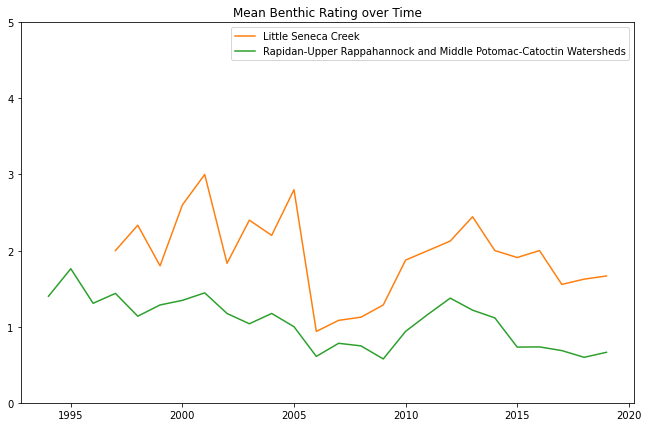

In [12]:
plt.figure(figsize = (11, 7))
plt.plot(benthic[benthic['HUC12_'] == '020700080801'].groupby('YEAR').mean(), label = huc_12.loc[huc_12['HUC12'] == '020700080801', 'NAME'].values[0], color = 'tab:orange')
plt.plot(benthic.loc[(benthic['HUC12_'].str.startswith('02080103') | benthic['HUC12_'].str.startswith('02070008'))].groupby('YEAR').mean(), label = 'Rapidan-Upper Rappahannock and Middle Potomac-Catoctin Watersheds', color = 'tab:green')
plt.title("Mean Benthic Rating over Time")
plt.ylim((0, 5))
plt.legend();
plt.savefig('Images/LittleSenecaCreekTimeSeries.png', transparent = True)

### Map benthic measurements in Little Seneca Creek subwatershed

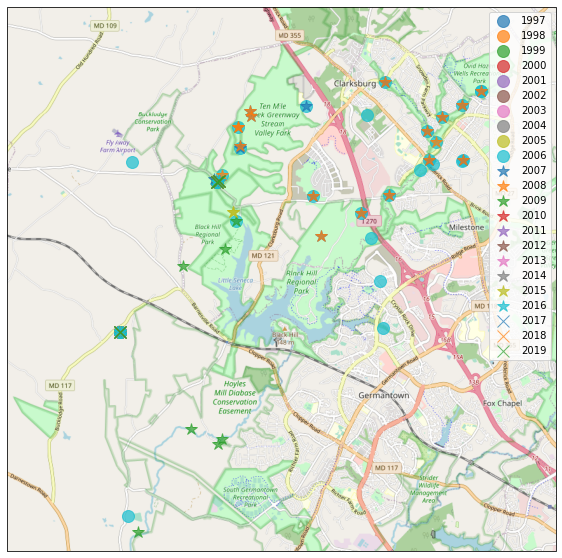

<Figure size 432x288 with 0 Axes>

In [13]:
imagery = OSM()
x0, y0, x1, y1 = huc_12.loc[huc_12['HUC12'] == '020700080801'].unary_union.bounds

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

ax.add_image(imagery, 13)
for year, m in zip(benthic.loc[benthic['HUC12_'] == '020700080801', 'YEAR'].unique(),
                  ['o','o','o','o','o','o','o','o','o','o','*','*','*','*','*','*','*','*','*','*','x','x','x']):
    ax.plot(
        benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'] == '020700080801'), 'Longitude'].astype('float'),
        benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'] == '020700080801'), 'Latitude'].astype('float'),
        transform = ccrs.PlateCarree(),
        marker = m,
        linestyle = '',
        label = year,
        alpha = 0.7,
        markersize = 12
    )
plt.legend()
plt.show()
plt.savefig('Images/LittleSenecaSites.png', transparent = True)

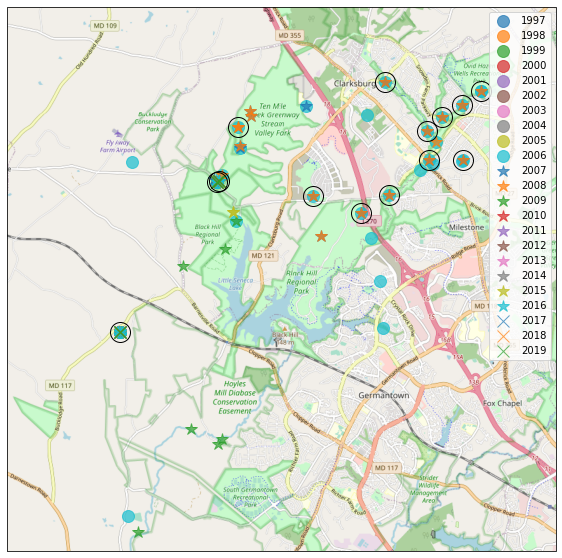

<Figure size 432x288 with 0 Axes>

In [14]:
imagery = OSM()
x0, y0, x1, y1 = huc_12.loc[huc_12['HUC12'] == '020700080801'].unary_union.bounds

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

ax.add_image(imagery, 13)
for year, m in zip(benthic.loc[benthic['HUC12_'] == '020700080801', 'YEAR'].unique(),
                  ['o','o','o','o','o','o','o','o','o','o','*','*','*','*','*','*','*','*','*','*','x','x','x']):
    ax.plot(
        benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'] == '020700080801'), 'Longitude'].astype('float'),
        benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'] == '020700080801'), 'Latitude'].astype('float'),
        transform = ccrs.PlateCarree(),
        marker = m,
        linestyle = '',
        label = year,
        alpha = 0.7,
        markersize = 12
    )
    
for long, lat in zip(
    benthic.loc[benthic['HUC12_'] == '020700080801'].groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Longitude'].astype('float'),
    benthic.loc[benthic['HUC12_'] == '020700080801'].groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Latitude'].astype('float'),
):
    if benthic.loc[(benthic['HUC12_'] == '020700080801') & (benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].shape[0] > 2:
        ax.plot(
            long,
            lat,
            transform = ccrs.PlateCarree(),
            marker = 'o',
            linestyle = '',
            markersize = 20,
            fillstyle = 'none',
            markeredgecolor = 'k',
        )
    
plt.legend()
plt.show()
plt.savefig('Images/LittleSenecaRepeatedSites.png', transparent = True)

### Plot benthic rating time series for Little Seneca Creek subwatershed and Chesapeake Bay watershed

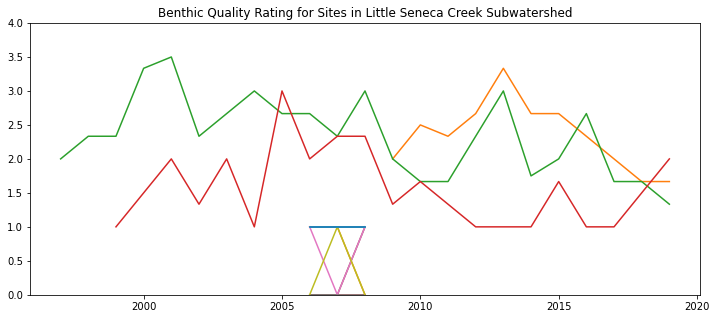

In [15]:
plt.figure(figsize = (12, 5))
for long, lat in zip(
    benthic.loc[benthic['HUC12_'] == '020700080801'].groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Longitude'].astype('float'),
    benthic.loc[benthic['HUC12_'] == '020700080801'].groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Latitude'].astype('float'),
):
    if benthic.loc[(benthic['HUC12_'] == '020700080801') & (benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].shape[0] > 2:
        plt.plot(
            benthic.loc[(benthic['HUC12_'] == '020700080801') & (benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].groupby('YEAR').mean()['rating']
        )
plt.ylim((0,4))
plt.title("Benthic Quality Rating for Sites in Little Seneca Creek Subwatershed");
plt.savefig('Images/LittleSenecaSitesTimeSeries.png', transparent = True)

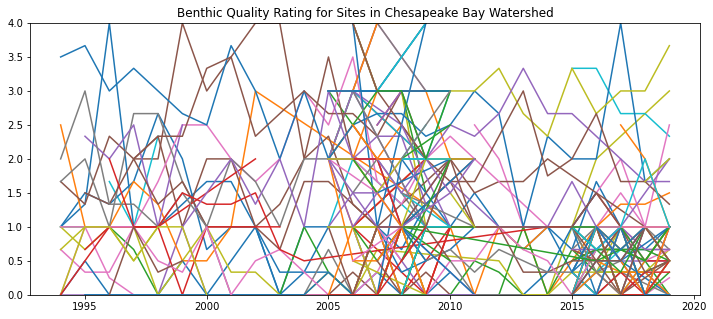

In [16]:
plt.figure(figsize = (12, 5))
for long, lat in zip(
    benthic.groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Longitude'].astype('float'),
    benthic.groupby(['Longitude','Latitude']).count()[['unique_id']].reset_index()['Latitude'].astype('float'),
):
    if benthic.loc[(benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].shape[0] > 2:
        plt.plot(
            benthic.loc[(benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].groupby('YEAR').mean()['rating']
        )
plt.ylim((0,4))
plt.title("Benthic Quality Rating for Sites in Chesapeake Bay Watershed");
plt.savefig('Images/ChesapeakeSitesTimeSeries.png', transparent = True)

### Generate dataframe of benthic measurment sites and rating trends

In [17]:
benthic_trends = {
    'Latitude': [],
    'Longitude': [],
    'Trend': []
}

for lat, long in zip(benthic['Latitude'].astype('float'), benthic['Longitude'].astype('float')):
    if benthic.loc[(benthic['Longitude'].astype('float') == long) & (benthic['Latitude'].astype('float') == lat)].shape[0] > 2:
        benthic_trends['Latitude'].append(lat)
        benthic_trends['Longitude'].append(long)
        benthic_trends['Trend'].append(benthic.loc[(benthic['Latitude'].astype('float') == lat) & (benthic['Longitude'].astype('float') == long)].groupby(['YEAR']).mean()['rating'].diff().sum())
benthic_trends_df = pd.DataFrame(benthic_trends).drop_duplicates()

### Map trend values for sites with repeated benthic measurments

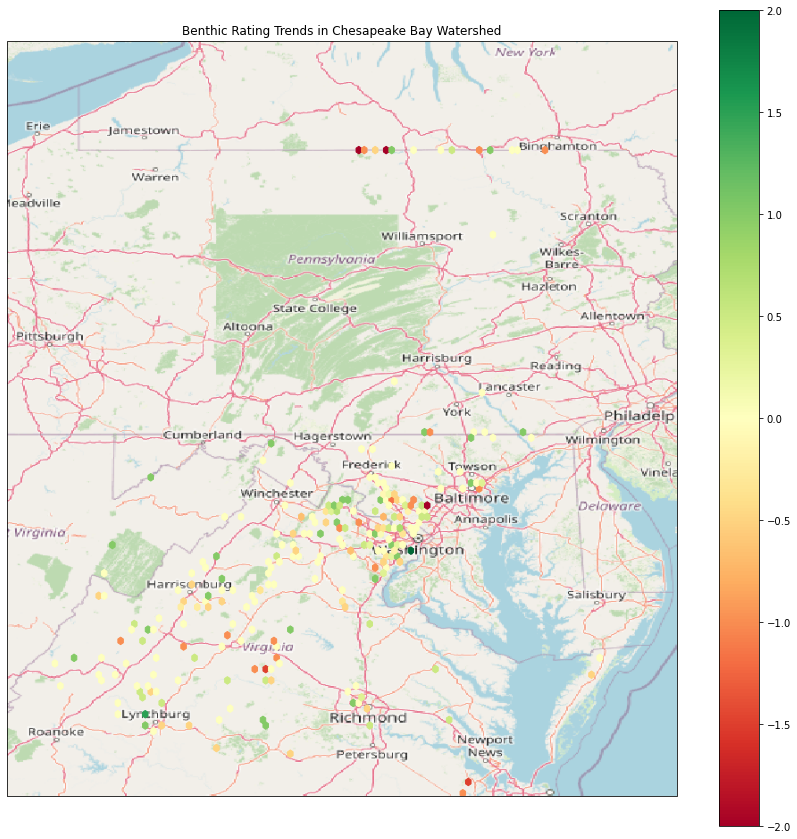

In [18]:
imagery = OSM()

x0 = benthic['Longitude'].astype('float').min()
x1 = benthic['Longitude'].astype('float').max()
y0 = benthic['Latitude'].astype('float').min()
y1 = benthic['Latitude'].astype('float').max()

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

hb = ax.hexbin(benthic_trends_df['Longitude'], 
               benthic_trends_df['Latitude'], 
               benthic_trends_df['Trend'], 
               transform = ccrs.PlateCarree(),
               cmap = 'RdYlGn')
plt.colorbar(hb)

ax.add_image(imagery, 7)
plt.title("Benthic Rating Trends in Chesapeake Bay Watershed")
plt.show()

### Map CMC and CBP water quality measurements

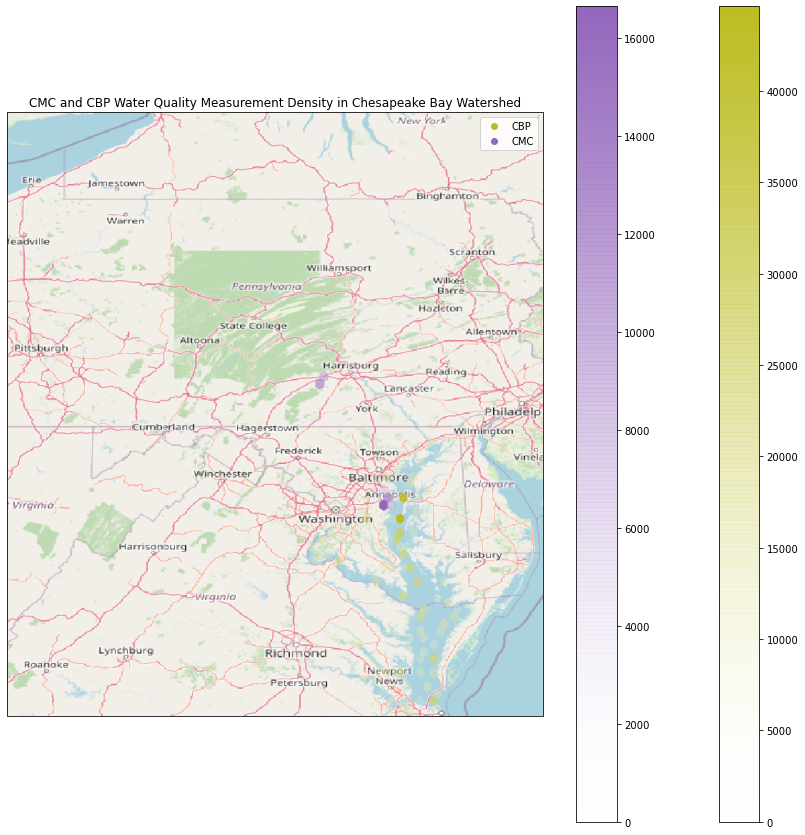

In [19]:
imagery = OSM()

x0 = benthic['Longitude'].astype('float').min()
x1 = benthic['Longitude'].astype('float').max()
y0 = benthic['Latitude'].astype('float').min()
y1 = benthic['Latitude'].astype('float').max()

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

for label, color in zip(('CBP', 'CMC'), ('tab:olive', 'tab:purple')):

    plt.scatter(x0, y0, color = color, label = label, zorder = 0)

    hb = plt.hexbin(df.loc[df['Database'] == label,'Xcoord'], 
                     df.loc[df['Database'] == label,'Ycoord'],
                     transform = ccrs.PlateCarree(),
                     cmap = colorcmap(color),
                     gridsize = 70
                    )
    plt.colorbar(hb)
plt.legend()
plt.title("CMC and CBP Water Quality Measurement Density in Chesapeake Bay Watershed")
ax.add_image(imagery, 7)